Group Members: Asha Karmakar, Akhil Iyer, Megan Sundheim, Grace Kim

In [25]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import imblearn
import math

from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

<p> https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features </p>

<h1> Data Preprocessing & Exploration </h1>

In [2]:
# Read in csv file
df = pd.read_csv("./data/genres.csv", low_memory=False)

In [3]:
# Clean data
# Remove the following columns: type, id, uri, track_href, analysis_url, unnamed, title, song_name
df = df[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'genre']]

# Building dataset for Decision Tree

In [14]:
df_dt = df.copy()
features_dt = df_dt.drop('genre', axis=1)
labels_dt = df_dt['genre']

from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

import random

y_pred_list = []

envelope_pred = EllipticEnvelope().fit_predict(features_dt)
y_pred_list.append(envelope_pred)

# apply IsolationForest AD
forest_pred = IsolationForest().fit_predict(features_dt)
y_pred_list.append(forest_pred)

# apply LocalOutlierFactor AD
lof_pred = LocalOutlierFactor().fit_predict(features_dt)
y_pred_list.append(lof_pred)

from collections import Counter

features_no_anomalies = features_dt.copy()
labels_no_anomalies = labels_dt.copy()
anomaly_indices = set()
for arr in y_pred_list:
    c = Counter(arr)
    print(c)
    i = len(arr) - 1
    while i >= 0:
        if arr[i] == -1:
            anomaly_indices.add(i)
        i -= 1
        
# Drop anomalies indicated by any of the 3 anomaly detection algorithms.
anomaly_indices = list(anomaly_indices)
anomaly_indices.sort()
features_no_anomalies = features_no_anomalies.drop(anomaly_indices, axis=0)
labels_no_anomalies = labels_no_anomalies.drop(anomaly_indices, axis=0)

features_no_anomalies = features_no_anomalies.reset_index().drop('index', axis=1)
labels_no_anomalies = labels_no_anomalies.reset_index().drop('index', axis=1)
label_groups_dt = labels_no_anomalies.groupby('genre')

min_size = math.inf
for genre in label_groups_dt.groups.keys():
    genre_group = label_groups_dt.get_group(genre)
    if len(genre_group) < min_size:
        min_size = len(genre_group)
num_samples = min_size

# Sample same number of points from each genre to balance classes.
samp_features = []
samp_genres = []
samp_records = []
df_no_anomalies = pd.DataFrame(features_no_anomalies.copy())
df_no_anomalies['genre'] = labels_no_anomalies
genres = df_no_anomalies.groupby('genre')
for genre in genres.groups.keys():
    genre_group = genres.get_group(genre)
    genre_group_copy = genre_group.copy()
    genre_group_copy = genre_group_copy.reset_index()
    for i in range(num_samples):
        index = random.randint(0, len(genre_group_copy) - 1)
        samp_records.append(genre_group_copy.iloc[index, :])

samp_features_dt = pd.DataFrame(samp_records).set_index('index')
samp_genres_dt = samp_features_dt['genre']
samp_features_dt = samp_features_dt.drop('genre', axis=1)

Counter({1: 38074, -1: 4231})
Counter({1: 36752, -1: 5553})
Counter({1: 40473, -1: 1832})


# Build dataset for rest

In [8]:
# one hot encode time signature
df = pd.get_dummies(df, columns=['time_signature'], drop_first=False)
df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,genre,time_signature_1,time_signature_3,time_signature_4,time_signature_5
0,0.831,0.814,2,-7.364,1,0.4200,0.059800,0.013400,0.0556,0.3890,156.985,124539,Dark Trap,False,False,True,False
1,0.719,0.493,8,-7.230,1,0.0794,0.401000,0.000000,0.1180,0.1240,115.080,224427,Dark Trap,False,False,True,False
2,0.850,0.893,5,-4.783,1,0.0623,0.013800,0.000004,0.3720,0.0391,218.050,98821,Dark Trap,False,False,True,False
3,0.476,0.781,0,-4.710,1,0.1030,0.023700,0.000000,0.1140,0.1750,186.948,123661,Dark Trap,False,True,False,False
4,0.798,0.624,2,-7.668,1,0.2930,0.217000,0.000000,0.1660,0.5910,147.988,123298,Dark Trap,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42300,0.528,0.693,4,-5.148,1,0.0304,0.031500,0.000345,0.1210,0.3940,150.013,269208,hardstyle,False,False,True,False
42301,0.517,0.768,0,-7.922,0,0.0479,0.022500,0.000018,0.2050,0.3830,149.928,210112,hardstyle,False,False,True,False
42302,0.361,0.821,8,-3.102,1,0.0505,0.026000,0.000242,0.3850,0.1240,154.935,234823,hardstyle,False,False,True,False
42303,0.477,0.921,6,-4.777,0,0.0392,0.000551,0.029600,0.0575,0.4880,150.042,323200,hardstyle,False,False,True,False


In [9]:
# Separate data into features and class labels
features = df.drop('genre', axis=1)
labels = df['genre']

In [10]:
print(features.head())
label_groups = df.groupby('genre')
print(label_groups.size())

   danceability  energy  key  loudness  mode  speechiness  acousticness   
0         0.831   0.814    2    -7.364     1       0.4200        0.0598  \
1         0.719   0.493    8    -7.230     1       0.0794        0.4010   
2         0.850   0.893    5    -4.783     1       0.0623        0.0138   
3         0.476   0.781    0    -4.710     1       0.1030        0.0237   
4         0.798   0.624    2    -7.668     1       0.2930        0.2170   

   instrumentalness  liveness  valence    tempo  duration_ms   
0          0.013400    0.0556   0.3890  156.985       124539  \
1          0.000000    0.1180   0.1240  115.080       224427   
2          0.000004    0.3720   0.0391  218.050        98821   
3          0.000000    0.1140   0.1750  186.948       123661   
4          0.000000    0.1660   0.5910  147.988       123298   

   time_signature_1  time_signature_3  time_signature_4  time_signature_5  
0             False             False              True             False  
1           

In [11]:
# There are no missing values:
null_data = df[df.isnull().any(axis=1)]
len(null_data)

0

[Text(0.5, 0, 'danceability'),
 Text(1.5, 0, 'energy'),
 Text(2.5, 0, 'key'),
 Text(3.5, 0, 'loudness'),
 Text(4.5, 0, 'mode'),
 Text(5.5, 0, 'speechiness'),
 Text(6.5, 0, 'acousticness'),
 Text(7.5, 0, 'instrumentalness'),
 Text(8.5, 0, 'liveness'),
 Text(9.5, 0, 'valence'),
 Text(10.5, 0, 'tempo'),
 Text(11.5, 0, 'duration_ms'),
 Text(12.5, 0, 'time_signature_1'),
 Text(13.5, 0, 'time_signature_3'),
 Text(14.5, 0, 'time_signature_4'),
 Text(15.5, 0, 'time_signature_5')]

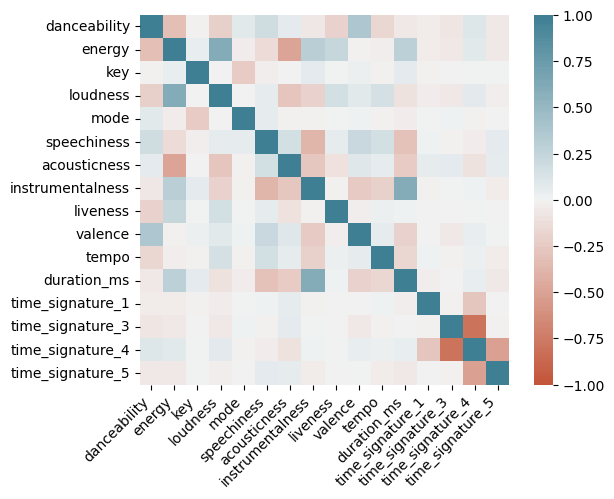

In [12]:
# correlation between features

ax = sns.heatmap(
    features.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

In [13]:
# Perform Anomaly Detection.
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

y_pred_list = []

envelope_pred = EllipticEnvelope().fit_predict(features)
y_pred_list.append(envelope_pred)

# apply IsolationForest AD
forest_pred = IsolationForest().fit_predict(features)
y_pred_list.append(forest_pred)

# apply LocalOutlierFactor AD
lof_pred = LocalOutlierFactor().fit_predict(features)
y_pred_list.append(lof_pred)

y_pred_list

[array([ 1, -1,  1, ...,  1,  1,  1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 1])]

In [14]:
# Drop anomalous points.
from collections import Counter

features_no_anomalies = features.copy()
labels_no_anomalies = labels.copy()
anomaly_indices = set()
for arr in y_pred_list:
    c = Counter(arr)
    print(c)
    i = len(arr) - 1
    while i >= 0:
        if arr[i] == -1:
            anomaly_indices.add(i)
        i -= 1
        
# Drop anomalies indicated by any of the 3 anomaly detection algorithms.
anomaly_indices = list(anomaly_indices)
anomaly_indices.sort()
features_no_anomalies = features_no_anomalies.drop(anomaly_indices, axis=0)
labels_no_anomalies = labels_no_anomalies.drop(anomaly_indices, axis=0)

features_no_anomalies = features_no_anomalies.reset_index().drop('index', axis=1)
labels_no_anomalies = labels_no_anomalies.reset_index().drop('index', axis=1)
label_groups = labels_no_anomalies.groupby('genre')
print(label_groups.size())
print("\nSize of new dataset: %i" % len(features_no_anomalies))
#TODO bar graph

Counter({1: 38074, -1: 4231})
Counter({1: 37448, -1: 4857})
Counter({1: 40473, -1: 1832})
genre
Dark Trap          3082
Emo                1240
Hiphop             2013
Pop                 355
Rap                1301
RnB                1383
Trap Metal         1378
Underground Rap    4137
dnb                2762
hardstyle          2657
psytrance          2684
techhouse          2695
techno             2442
trance             2753
trap               2704
dtype: int64

Size of new dataset: 33586


In [15]:
# Print the labeled data clusters after anomalies taken out.

#TODO fix the issue


# TODO fix scaling (may want with no anomalies?)
import random
from sklearn.manifold import MDS

#TODO from hw 5
# do not change this plotting function!

# Scale non-anomalous data.
scaler = sk.preprocessing.StandardScaler()
features_scaled = scaler.fit_transform(features_no_anomalies)
pca = sk.decomposition.PCA(n_components=0.95, svd_solver='full')
features_scaled = pca.fit_transform(features_scaled)
numPoints = 1000
numEntries = features_scaled.shape[0]
samp_records = []
samp_labels = []
for i in range(numPoints):
    index = random.randint(0, numEntries - 1)
    samp_records.append(features_scaled[index, :])
    samp_labels.append(labels_no_anomalies[index])

label_colors = []
color_dict = dict()
for label in samp_labels:
    if not label in color_dict.keys():
        # Originally found in https://stackoverflow.com/questions/28999287/generate-random-colors-rgb.
        color = "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
        color_dict[label] = color
    label_colors.append(color_dict[label])


mds = MDS(n_components=2)
mds_data = mds.fit_transform(samp_records)

classes = dict()
for i in range(len(mds_data)):
    record = mds_data[i]
    label = samp_labels[i]
    if not label in classes.keys():
        classes[label] = [record]
    else:
        classes[label].append(record)

fig, axes = plt.subplots(len(classes.keys()) + 1, 1, figsize=(6, 100), sharey=True, sharex=True)
index = 1
for genre in classes.keys():
    ax = axes[index]
    index += 1
    data = pd.DataFrame(classes[genre])
    color = [color_dict[genre] for i in range(len(data))]
    axes[0].scatter(data.iloc[:, 0], data.iloc[:, 1], c=color, s=50, label=genre)
    ax.scatter(data.iloc[:, 0], data.iloc[:, 1], c=color, s=50, label=genre)

# Originally found in https://towardsdatascience.com/legend-outside-the-plot-matplotlib-5d9c1caa9d31#:~:text=Placing%20the%20legend%20outside%20of%20the%20plot&text=First%2C%20we%20need%20to%20shrink,control%20for%20manual%20legend%20placement.&text=Box%20that%20is%20used%20to,Defaults%20to%20axes.
axes[0].legend(loc='center right', bbox_to_anchor=(1.4, 0.5))
index = 1
while index <= len(classes.keys()):
    ax = axes[index]
    ax.legend(loc='best')
    index += 1

KeyError: 21793

In [34]:
# Downsample data to mitigate for class imbalance.
min_size = math.inf
for genre in label_groups.groups.keys():
    genre_group = label_groups.get_group(genre)
    if len(genre_group) < min_size:
        min_size = len(genre_group)
num_samples = min_size

# Sample same number of points from each genre to balance classes.
samp_features = []
samp_genres = []
samp_records = []
df_no_anomalies = pd.DataFrame(features_no_anomalies.copy())
df_no_anomalies['genre'] = labels_no_anomalies
genres = df_no_anomalies.groupby('genre')
for genre in genres.groups.keys():
    genre_group = genres.get_group(genre)
    genre_group_copy = genre_group.copy()
    genre_group_copy = genre_group_copy.reset_index()
    for i in range(num_samples):
        index = random.randint(0, len(genre_group_copy) - 1)
        samp_records.append(genre_group_copy.iloc[index, :])

samp_features = pd.DataFrame(samp_records).set_index('index')
samp_genres = samp_features['genre']
samp_features = samp_features.drop('genre', axis=1)
print(samp_features)
print(samp_genres)

for genre in classes.keys():
    # Sum WSS over each genre.
    cohesion = 0
    data = df_no_anomalies[df_no_anomalies['genre'] == genre].drop('genre', axis=1)
    centroid = np.mean(data, axis=0)

print(samp_genres.groupby('genre').size())

       danceability  energy  key  loudness  mode  speechiness  acousticness   
index                                                                         
2552          0.614   0.616    2   -10.575     0       0.0614       0.16900  \
3053          0.580   0.527    1    -7.584     1       0.0365       0.00197   
1100          0.822   0.901   11    -4.511     1       0.0375       0.24100   
2410          0.543   0.664    2    -6.627     1       0.0267       0.01500   
1369          0.633   0.787    9    -6.815     0       0.0694       0.09880   
...             ...     ...  ...       ...   ...          ...           ...   
25935         0.468   0.957    9    -0.304     1       0.1150       0.02700   
27291         0.655   0.876    5    -4.173     0       0.0903       0.00753   
25742         0.621   0.882    3    -0.771     0       0.0338       0.02340   
25996         0.555   0.957    6    -1.587     1       0.1260       0.00101   
26204         0.678   0.975    7    -0.922     0    

NameError: name 'classes' is not defined

In [ ]:
# TODO check for separation in original classes to decide if we want to group genres together

<h1> Model Building </h1>

### Naive Bayes Classification

As part of our group's brainstorming process for which classifier types would be most appropriate to train our data on, we chose to try Naive Bayes since it is not susceptible to the curse of dimensionality (and we have a quite a few features we are using). Since Naive Bayes assumes that all features are conditionally independent of each other given the label and our features were weakly correlated with each other, we thought this was an additional reason this classifier could be appropriate.

Gaussian Naive Bayes was the only subtype of this classifier that we were able to use since it allowed for use of continuous feature values. Multinomial and Categorical required discrete feature values, Complement needed nonnegative values, and Bernoilli relied on binary feature values, so we couldn't use any of these while using all of our features (original and reduced dimensionality).

In [ ]:
# TODO maybe group with dropping anomalies
import sklearn.naive_bayes

# Create a Gaussian Naive Bayes classifier.
gnb = sk.naive_bayes.GaussianNB()

# Run 10-fold cross validation on classifier.
accuracies = sk.model_selection.cross_val_score(gnb, features, list(labels), cv=10)

# Print the accuracy of the cross-validated model.
avg_accuracy = accuracies.mean()
print("Accuracy:", (avg_accuracy * 100))


# Create a Gaussian Naive Bayes classifier for data without anomalies.
gnb_no_anomalies = sk.naive_bayes.GaussianNB()
labels_no_anomalies = labels_no_anomalies.iloc[:, 0]

# Run 10-fold cross validation on classifier for data without anomalies.
accuracies_no_anomalies = sk.model_selection.cross_val_score(gnb_no_anomalies, features_no_anomalies, labels_no_anomalies, cv=10)

# Print the accuracy of the cross-validated model for data without anomalies.
avg_accuracy_no_anomalies = accuracies_no_anomalies.mean()
print("Accuracy without anomalies:", (avg_accuracy_no_anomalies * 100))

In [ ]:
# Original code from Megan Sundheim's HW 4.

# Print the confusion matrix for the classifier.
pred_labels = sk.model_selection.cross_val_predict(gnb, features, labels, cv=10)
con_mat = sk.metrics.confusion_matrix(labels, pred_labels)
print("Confusion matrix:\n", con_mat)
#TODO make into snazzy heat map

# Display the classification report for the Naive Bayes classifier.
report = sk.metrics.classification_report(labels, pred_labels)
print("\nClassification Report:\n", report)


# Print the confusion matrix for the classifier without anomalies.
pred_labels_no_anomalies = sk.model_selection.cross_val_predict(gnb_no_anomalies, features_no_anomalies, labels_no_anomalies, cv=10)
con_mat_no_anomalies = sk.metrics.confusion_matrix(labels_no_anomalies, pred_labels_no_anomalies)
print("Confusion matrix:\n", con_mat)
#TODO make into snazzy heat map

# Display the classification report for the Naive Bayes classifier without anomalies.
report_no_anomalies = sk.metrics.classification_report(labels_no_anomalies, pred_labels_no_anomalies)
report_no_anomalies_dict = sk.metrics.classification_report(labels_no_anomalies, pred_labels_no_anomalies, output_dict=True)
print("\nClassification Report:\n", report_no_anomalies)

In [ ]:
# TODO move to evaluation section
import math
rel_cohesion = dict()
df_no_anomalies = pd.DataFrame(features_no_anomalies.copy())
df_no_anomalies['genre'] = labels_no_anomalies

# Calculate the cohesion (similarity) between points in each genre.
for genre in classes.keys():
    # Sum WSS over each genre.
    cohesion = 0
    data = df_no_anomalies[df_no_anomalies['genre'] == genre].drop('genre', axis=1)
    centroid = np.mean(data, axis=0)
    for i in range(0, len(data)):
        # Sum WSS over each data point in current cluster.
        record = data.iloc[i, :]
        cohesion += (math.sqrt(((record[0] - centroid[0]) ** 2) + (record[1] - centroid[1]) ** 2)) ** 2
    print("The cohesion of records in %s is %f." % (genre, cohesion))
    print("The cohesion of records in %s, relative to size, is %f.\n" % (genre, (cohesion / len(data))))
    rel_cohesion[genre] = cohesion / len(data)
    
# Sum WSS over all genres.
total_cohesion = 0
total_c = np.mean(features_no_anomalies, axis=0)
for i in range(len(features_no_anomalies)):
    record = features_no_anomalies.iloc[i, :]
    total_cohesion += (math.sqrt(((record[0] - total_c[0]) ** 2) + (record[1] - total_c[1]) ** 2)) ** 2

rel_total = total_cohesion / len(features_no_anomalies)
print("The cohesion of all records is %f." % (total_cohesion))
print("The relative cohesion of all records is %f." % (rel_total))

In [ ]:
genre_f1 = dict()
genres = df.groupby('genre').groups.keys()
corr_df = []
for genre in genres:
    metrics = report_no_anomalies_dict[genre]
    f1 = metrics['f1-score']
    corr_df.append([f1, rel_cohesion[genre]])

corr_df = pd.DataFrame(corr_df, index=genres, columns=['f1-score', 'Relative Cohesion'])
print(corr_df.corr())

In [ ]:
# Run Naive Bayes on sampled data.
gnb_sampled = sk.naive_bayes.GaussianNB()

# Run 10-fold cross validation on classifier.
accuracies = sk.model_selection.cross_val_score(gnb_sampled, samp_features, samp_genres, cv=10)

# Print the accuracy of the cross-validated model.
avg_accuracy = accuracies.mean()
print("Accuracy:", (avg_accuracy * 100))

# TODO: look at classification report

In [ ]:
# SMOTE and visualized confusion matrix and ROC curve for each model and compare.

### Neural Networks

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.20, random_state=4)

scaler = StandardScaler()
pca = PCA()
mlp = MLPClassifier(random_state=1, early_stopping=True)

mlp_param = {
    'mlp__hidden_layer_sizes': list(range(90, 110, 10)),
    'mlp__activation': ('logistic', 'tanh', 'relu'),
    'mlp__solver': ('sgd','adam')
}

mlp_pipe = Pipeline([('scaler', scaler), ('pca', pca), ('mlp', mlp)])
clf = GridSearchCV(mlp_pipe, mlp_param, n_jobs=-1, cv=5)
clf.fit(x_train, y_train) # X is train samples and y is the corresponding labels

In [ ]:
print('Best parameters found:\n', clf.best_params_)

In [ ]:
y_true, y_pred = y_test , clf.predict(x_test)
from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

In [ ]:
from sklearn import metrics
import seaborn as sn

cm=metrics.confusion_matrix(y_test,y_pred)
plt.figure(figsize = (10,7))
sn.set(font_scale=1.2)
sn.heatmap(cm, annot=True, fmt='g')

#df_cm = pd.DataFrame(cm, index = [i for i in "ABCDEFGHIJK"], columns = [i for i in ]

In [ ]:
scaler = StandardScaler()
mlp = MLPClassifier(random_state=1, early_stopping=True, verbose=True)

mlp_param = {
    'mlp__hidden_layer_sizes': list(range(13,15,1)),
    'mlp__solver': ('sgd', 'lbfgs', 'adam')
}

mlp_pipe = Pipeline([('scaler', scaler), ('mlp', mlp)])
mlp_grid = GridSearchCV(mlp_pipe, mlp_param, cv=2)
avg_acc = np.mean(cross_val_score(mlp_grid, features, labels, cv=2))
mlp.fit(features, labels)
print("Accuracy score: ", avg_acc)

### Decision Trees

#### Import

In [77]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from collections import Counter

import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

import seaborn as sns

%matplotlib inline

unique_genres = sorted(list(set(list(samp_genres_dt))))

#### Looking at data distribution

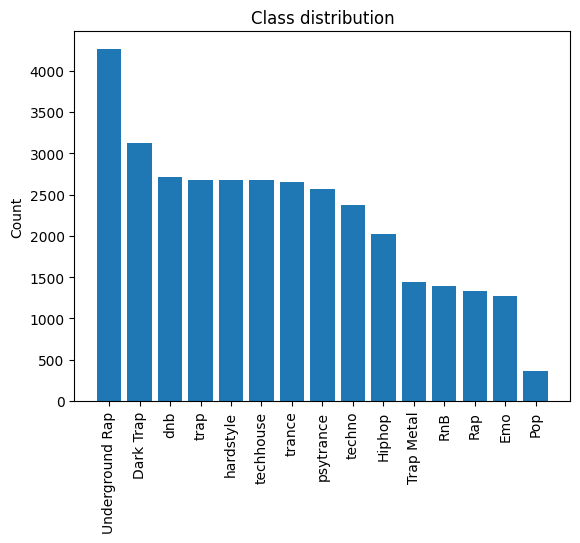

In [51]:
# Visualize label distribution in bar graph
labels_size = list(label_groups_dt.size())

genre_size = {k: v for k, v in zip(unique_genres, labels_size)}
sorted_f1_genre = {k: v for k, v in sorted(genre_size.items(), key=lambda item: item[1], reverse=True)}

x = list(sorted_f1_genre.keys())
y = list(sorted_f1_genre.values())

plt.bar(x, y)
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.title('Class distribution')
plt.show()

#### Functions

In [52]:
def plot_confusion_matrix(confusion_mat):
    ax = plt.subplot()
    sns.heatmap(confusion_mat, annot=True, fmt='g', ax=ax)

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(unique_genres, rotation=90)
    ax.yaxis.set_ticklabels(unique_genres, rotation=0)

In [76]:
def decision_tree_clf(features, labels):
    dt_model = tree.DecisionTreeClassifier()
    parameters = {'criterion':["gini", "entropy"], 'max_depth':[5, 10, 15, 20], 'min_samples_leaf':[5, 10, 15, 20], 'max_features': [5, 10, 15]}
    dt_grid = GridSearchCV(dt_model, parameters, scoring="accuracy", cv=10)
    dt_grid.fit(features, labels)
    
    best_params = dt_grid.best_params_
    
    dt_model = tree.DecisionTreeClassifier(criterion=best_params.get("criterion"), max_depth=best_params.get("max_depth"), min_samples_leaf=best_params.get("min_samples_leaf"), max_features=best_params.get("max_features"))
    
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    dt_model = dt_model.fit(X_train, y_train)
    y_pred = dt_model.predict(X_test)
    
    print(classification_report(y_test, y_pred))
    report = classification_report(y_test, y_pred, output_dict=True)
    
    confusion_mat = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(confusion_mat)
    
    return report

#### Plot F1 score by genre

In [54]:
def plot_f1_score(class_report):
    f1_genre = {genre: class_report[genre]['f1-score'] for genre in unique_genres}
    sorted_f1_genre = {k: v for k, v in sorted(f1_genre.items(), key=lambda item: item[1], reverse=True)}

    x = list(sorted_f1_genre.keys())
    y = list(sorted_f1_genre.values())

    plt.bar(x, y)

    plt.xticks(rotation=90)
    plt.ylabel('F1-score')
    plt.title('F1-score for each genre by decision tree classifier')

    plt.show()
    
    return f1_genre

#### Cohesion

In [55]:
def cohesion_corr(df, f1_genre):
    rel_cohesion = dict()
    for genre in unique_genres:
        cohesion = 0
        data = df[df['genre'] == genre].drop('genre', axis=1)
        centroid = np.mean(data, axis=0)
        for i in range(0, len(data)):
            record = data.iloc[i, :]
            cohesion += (math.sqrt(((record[0] - centroid[0]) ** 2) + (record[1] - centroid[1]) ** 2)) ** 2
        rel_cohesion[genre] = cohesion / len(data)

    sorted_cohesion = {k: v for k, v in sorted(rel_cohesion.items(), key=lambda item: item[1], reverse=True)}

    x = list(sorted_cohesion.keys())
    y = list(sorted_cohesion.values())

    plt.bar(x, y)

    plt.xticks(rotation=90)
    plt.ylabel('Cohesion')
    plt.title('Cohesion for each genre')

    plt.show()

    f1_genre_values = list(f1_genre.values())
    cohesion_values = list(rel_cohesion.values())

    plt.scatter(cohesion_values, f1_genre_values)

    plt.title("Scatterplot of Cohesion and F1 score")
    plt.xlabel("Cohesion")
    plt.ylabel("F1 score")

    plt.show()

    print("Correlation Coefficient between Cohesion and F1 score", np.corrcoef(f1_genre_values, cohesion_values)[0][1])

#### Separation

In [56]:
def separation_corr(df, f1_genre):
    overall_centroid = np.mean(samp_features_dt, axis=0)
    separation_stats = dict()
    centroid_dict = dict()
    for genre in unique_genres:
        data = df[df['genre'] == genre].drop('genre', axis=1)
        centroid_dict[genre] = np.mean(data, axis=0)
        crnt_centroid = np.mean(data, axis=0)
        dist = math.dist(overall_centroid, crnt_centroid) ** 2
        data_size = len(data)
        bss = dist * data_size
        separation_stats[genre] = bss

    sorted_separation = {k: v for k, v in sorted(separation_stats.items(), key=lambda item: item[1], reverse=True)}

    x = list(sorted_separation.keys())
    y = list(sorted_separation.values())

    plt.bar(x, y)

    plt.xticks(rotation=90)
    plt.ylabel('Separation')
    plt.title('Separation for each genre')

    plt.show()

    f1_genre_values = list(f1_genre.values())
    separation_values = list(separation_stats.values())

    plt.scatter(separation_values, f1_genre_values)

    plt.title("Scatterplot of Seperation and F1 score")
    plt.xlabel("Seperation")
    plt.ylabel("F1 score")

    plt.show()

    print("Correlation Coefficient between Sepearation and F1 score", np.corrcoef(f1_genre_values, separation_values)[0][1])

#### Training on original dataset for analysis purpose

                 precision    recall  f1-score   support

      Dark Trap       0.55      0.38      0.45       970
            Emo       0.57      0.59      0.58       341
         Hiphop       0.44      0.40      0.42       621
            Pop       0.56      0.05      0.09        98
            Rap       0.81      0.28      0.42       341
            RnB       0.30      0.32      0.31       396
     Trap Metal       0.38      0.24      0.30       384
Underground Rap       0.42      0.66      0.52      1192
            dnb       0.94      0.96      0.95       599
      hardstyle       0.82      0.82      0.82       619
      psytrance       0.91      0.87      0.89       598
      techhouse       0.84      0.86      0.85       568
         techno       0.80      0.82      0.81       590
         trance       0.76      0.81      0.79       562
           trap       0.73      0.79      0.76       582

       accuracy                           0.64      8461
      macro avg       0.66   

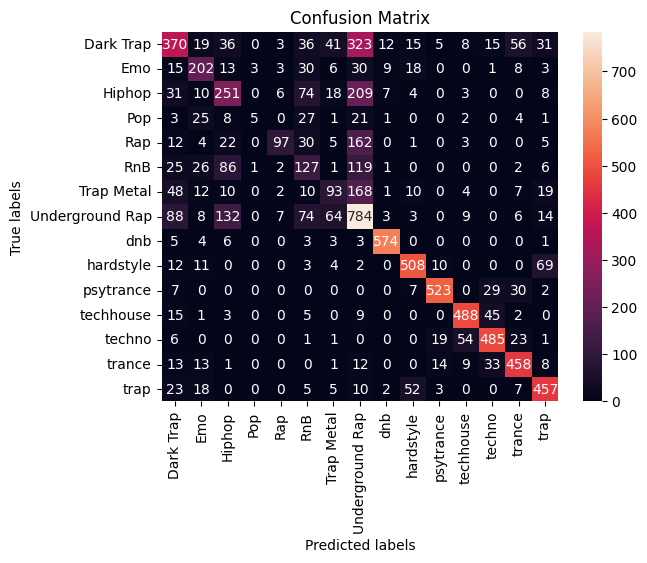

In [62]:
# Running decision tree in entire dataset
dt_report = decision_tree_clf(features_dt, labels_dt)

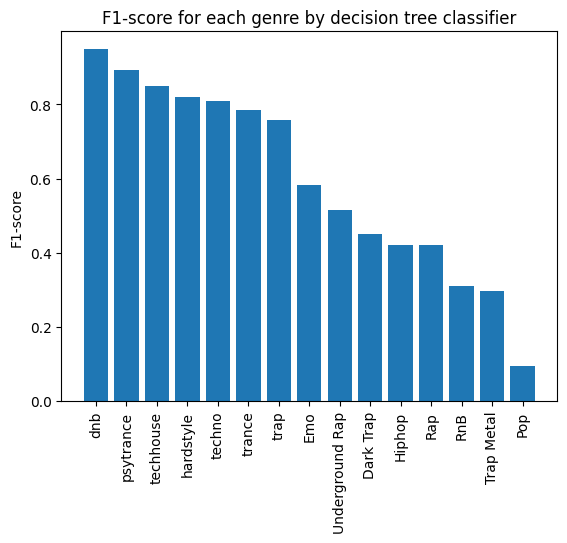

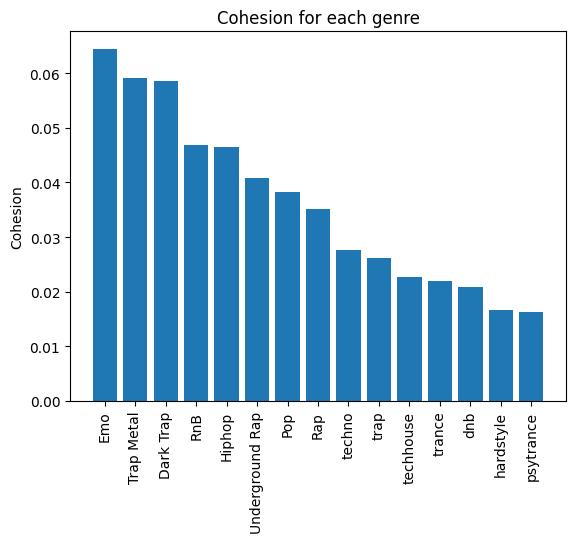

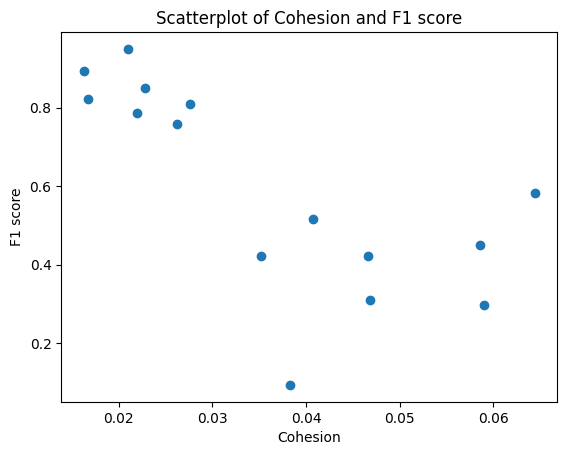

Correlation Coefficient between Cohesion and F1 score -0.7120983865789099


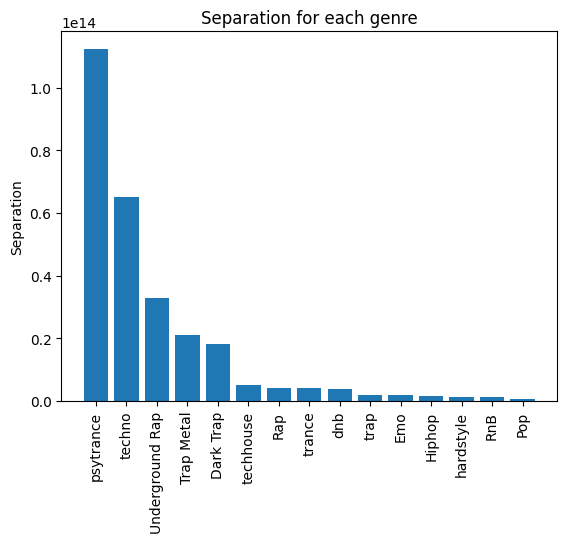

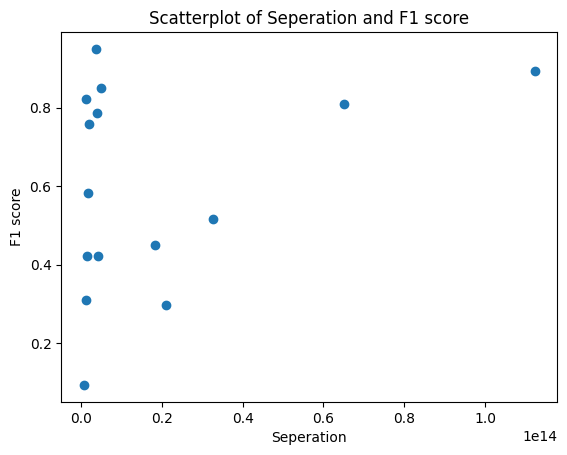

Correlation Coefficient between Sepearation and F1 score 0.3285706569912447


In [63]:
f1_genre = plot_f1_score(dt_report)
cohesion_corr(df, f1_genre)
separation_corr(df, f1_genre)

#### After Downsampling

                 precision    recall  f1-score   support

      Dark Trap       0.37      0.39      0.38        80
            Emo       0.54      0.58      0.56        77
         Hiphop       0.33      0.30      0.31        73
            Pop       0.37      0.50      0.42        74
            Rap       0.44      0.48      0.46        81
            RnB       0.31      0.25      0.27        73
     Trap Metal       0.47      0.34      0.39        77
Underground Rap       0.25      0.21      0.23        67
            dnb       0.87      0.87      0.87        61
      hardstyle       0.68      0.83      0.75        65
      psytrance       0.89      0.91      0.90        74
      techhouse       0.84      0.81      0.83        79
         techno       0.86      0.75      0.80        75
         trance       0.74      0.76      0.75        67
           trap       0.72      0.77      0.74        60

       accuracy                           0.58      1083
      macro avg       0.58   

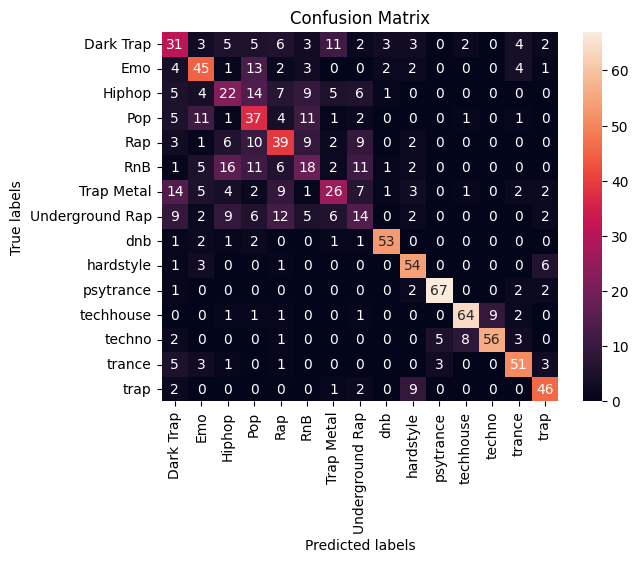

In [78]:
# Running decision tree after downsampling
dt_report = decision_tree_clf(samp_features_dt, samp_genres_dt)

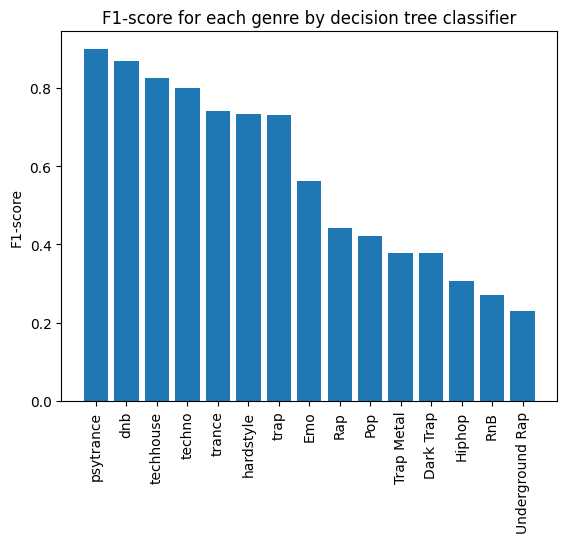

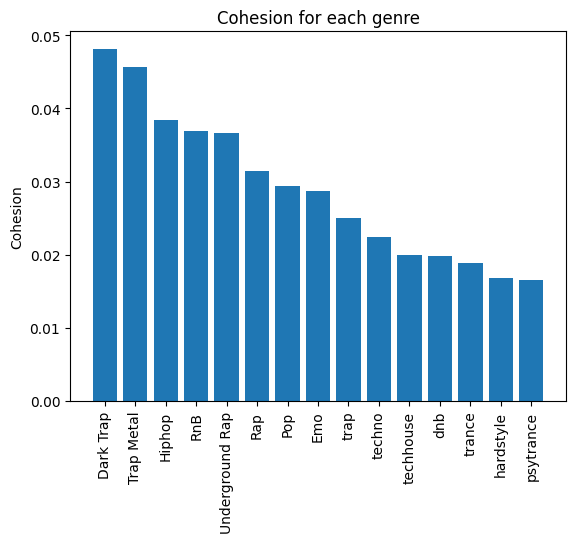

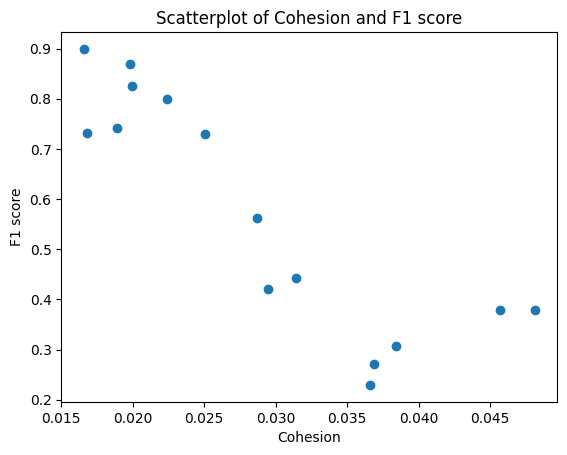

Correlation Coefficient between Cohesion and F1 score -0.8679671060631794


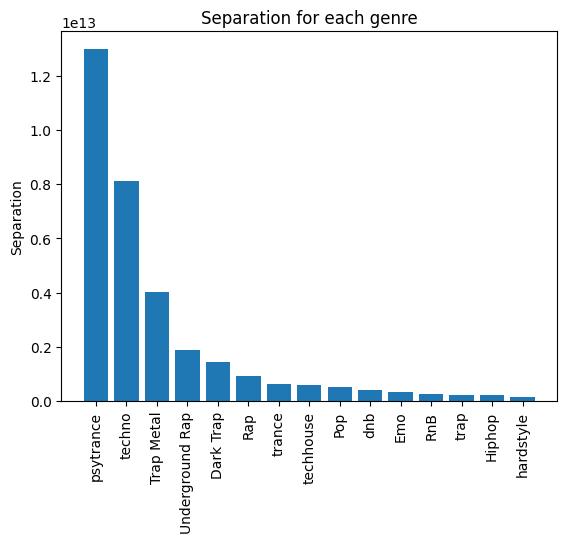

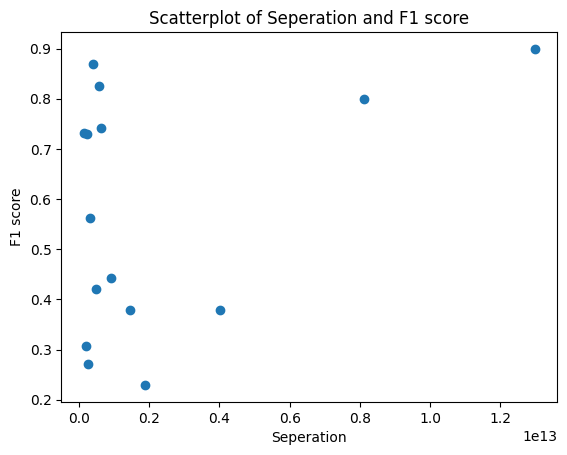

Correlation Coefficient between Sepearation and F1 score 0.37014921668529993


In [65]:
f1_genre = plot_f1_score(dt_report)
downsample_df = pd.concat([samp_features_dt, samp_genres_dt], axis=1)
cohesion_corr(downsample_df, f1_genre)
separation_corr(downsample_df, f1_genre)

#### Analysis

We decided that the decision tree model would be ideal for our task because we have lots of features and the decision tree model doesn't suffer from the curse of dimensionliaty. Also, we have combination of numerical and categorical features which makes our dataset ideal for using decision tree model.

We first tried to train the model on full dataset by splitting the dataset to train (.8) and test set (.2). We used grid search to find the most optimal hyperparameters for criterion, max_depth, min_samples_leaf, and max_features and use that hyperparameters to train the new model with train dataset and test it on the test dataset. We noticed that the certain genres achieve high accuracy while the others don't. Especially, the genres with more data tends to get higher accuracy. For example, the f-1 score of genre Pop was the lowest, and the number of data in original dataset was also the lowest.

Therefore, we downsampled the data to account for the class imbalance. After downsampling, we see that F-1 scores of genres are more evenly spread out. There are still genres that the model doesn't perform well. However, this is likely to due to the inherent characteristic of genre. For example, certain genre might be harder to distinguish than other genres because the values of features are similar to that of data from other genres.

Although the overall accuracy went down, we observe that genres that didn’t perform well before downsampling such as Pop perform much better.

We test whether there is correlation between WSS (Cohesion) and BSS (Separation) between how well the model performs on each genere (F1-score). For downsampled data, we get -0.82 as correlation coefficient between Cohesion and F1-score and 0.29 as that between Separation and F1-score. We see that there is stronger negative correlation between how cohesitive the data points in genre are and how well the model performs on that genre. We see there is positive correlation between how separable genre is from other genres and how well the model performs on that genre. However, there doesn't seem to be great positive correlation as the number is small and there are lots of genres where the WSS is close to 0. 

# Random Forest

### Function

In [66]:
def random_forest_clf(features, labels):
    rf_model = RandomForestClassifier()
    rf_param = {'n_estimators': list(range(50, 150, 50))}
    
    rf_param = GridSearchCV(rf_model, rf_param, scoring="accuracy", cv=10)
    rf_param.fit(features, labels)
    
    best_params = rf_param.best_params_
    
    rf_model = RandomForestClassifier(n_estimators=best_params.get("n_estimators"))
    
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    rf_model = rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    
    print(classification_report(y_test, y_pred))
    report = classification_report(y_test, y_pred, output_dict=True)
    
    confusion_mat = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(confusion_mat)
    
    # Importance of features
    importances = rf_model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
    forest_importances = pd.Series(importances, index=list(features.columns))

    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    
    return report

### Training

                 precision    recall  f1-score   support

      Dark Trap       0.61      0.42      0.50        80
            Emo       0.69      0.74      0.71        77
         Hiphop       0.51      0.52      0.52        73
            Pop       0.68      0.70      0.69        74
            Rap       0.49      0.63      0.55        81
            RnB       0.40      0.37      0.39        73
     Trap Metal       0.56      0.51      0.53        77
Underground Rap       0.25      0.24      0.25        67
            dnb       0.94      0.98      0.96        61
      hardstyle       0.80      0.82      0.81        65
      psytrance       0.85      0.95      0.90        74
      techhouse       0.83      0.87      0.85        79
         techno       0.88      0.80      0.84        75
         trance       0.83      0.88      0.86        67
           trap       0.86      0.80      0.83        60

       accuracy                           0.68      1083
      macro avg       0.68   

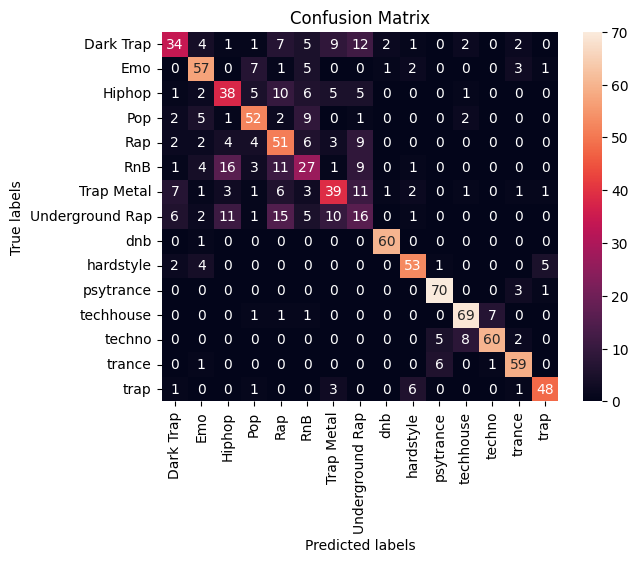

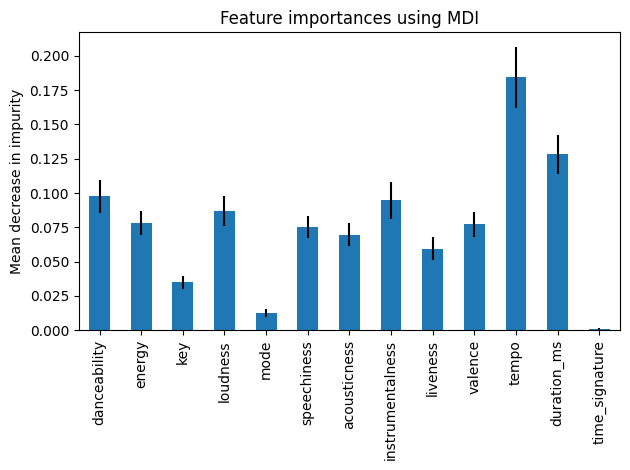

In [67]:
rf_report = random_forest_clf(samp_features_dt, samp_genres_dt)

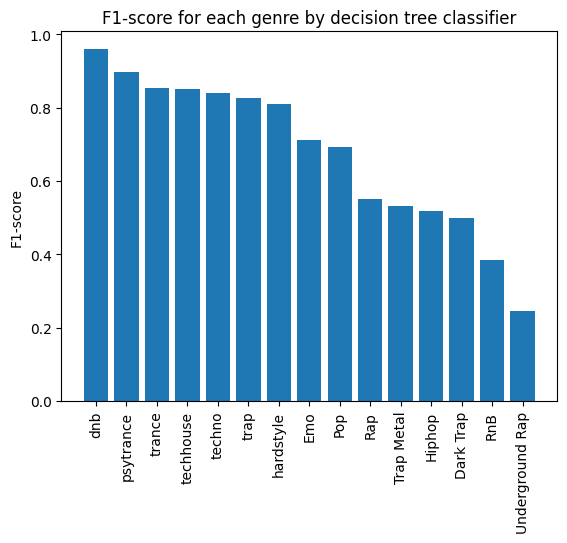

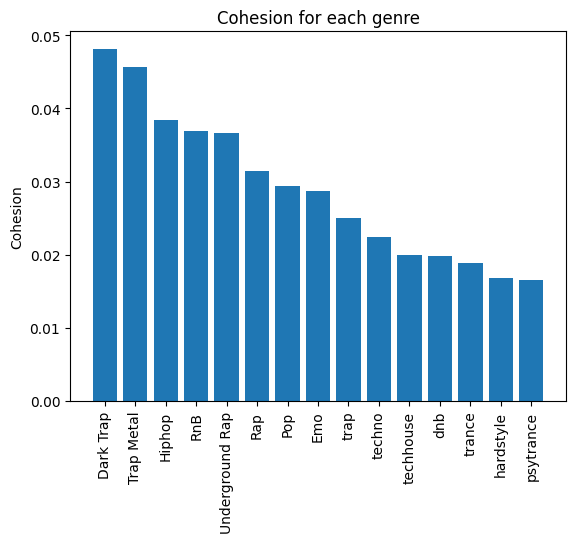

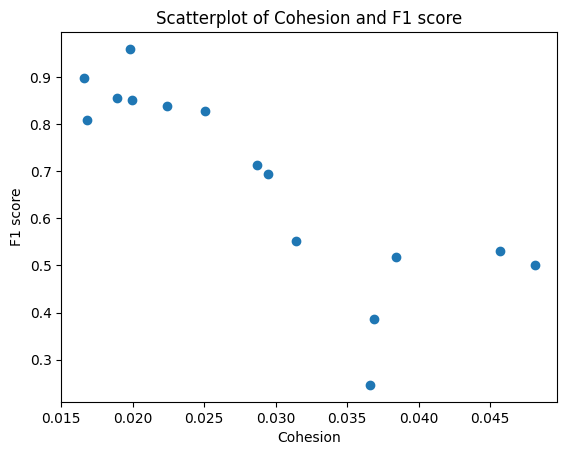

Correlation Coefficient between Cohesion and F1 score -0.826834125760055


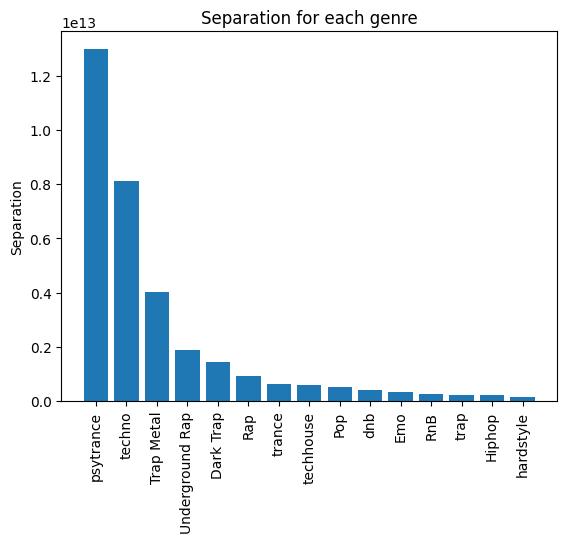

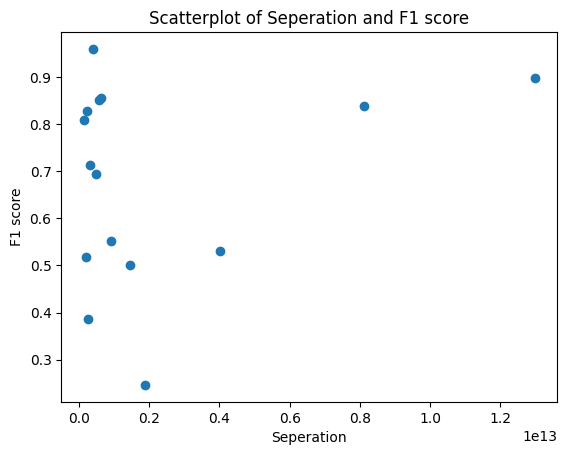

Correlation Coefficient between Sepearation and F1 score 0.24548901495519113


In [68]:
rf_f1_genre = plot_f1_score(rf_report)
downsample_df = pd.concat([samp_features_dt, samp_genres_dt], axis=1)
cohesion_corr(downsample_df, rf_f1_genre)
separation_corr(downsample_df, rf_f1_genre)

#### Analysis

We decided to use random forest model because it is suitable for our dataset with same reason as decision tree. Random forest model is supposed to better than decision tree because it predicts label by ensembling multiple decision trees and randomly selects a subset of input features rather than using all features for split. Thefore is better at not overfitting by relying on single best feature.

We see that random forest model performs much better than a single decision tree as the model's accuracy on test dataset went up signitificantly. When using only single decision tree, we got accuracy of 0.57. On same dataset, we get accuracy of 0.68.

We identify what features were most important by using mean decrease in impurity metrics. We see that tempo is the most imporatnt feature followed by duration of song as second most important feature. Features like mode and time signature were the least important features.

We see similar trend between cohesion measure and the model's performance on each genre and so as the separation measure. However, the absolute values of the correlation coefficient both went down.

### KNN

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

param_grid = {
    'pca__n_components': list(range(5, 16)),
    'knn__n_neighbors': list(range(1, 25))
}


knn_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()), ('knn', KNeighborsClassifier())])

knn_gscv = GridSearchCV(estimator=knn_pipe, param_grid=param_grid, scoring='accuracy', cv=5)

knn_gscv.fit(features, labels)

print("GridSearchCV Best Params: ", knn_gscv.best_params_)
print("GridSearchCV Best Score", knn_gscv.best_score_)

### K-Means

In [119]:
rel_cohesion_list

[17.393689802197795,
 10.998854766483529,
 15.173261337912091,
 10.088200799450554,
 10.43995104120879,
 13.61161345879121,
 16.509702524725267,
 12.904173906593401,
 7.84012030219781,
 5.856293392857139,
 5.79718781318681,
 7.839558785714281,
 7.31037396428572,
 7.547946414835166,
 9.09576998626373]

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import MDS

kmeans = KMeans(n_clusters=15)
kpred = kmeans.fit_predict(music_data_pca)
sil_score = silhouette_score(music_data_pca, kpred, metric='euclidean')

print (sil_score)

In [ ]:
import numpy as np
from math import e
import pandas as pd   

""" Usage: pandas_entropy(df['column1']) """

# Based on StackOverflow post: https://stackoverflow.com/questions/49685591/how-to-find-the-entropy-of-each-column-of-data-set-by-python
def pandas_gini(column, base=None):
    vc = pd.Series(column).value_counts(sort=False)
    base = e if base is None else base
    return 1 - (np.square((vc / len(column)))).sum()

entropies = []
cluster_labels = []
cluster_names = []

for k in range(0, 15):

    filtered_cluster = labels[kpred == k]

    lbl = filtered_cluster.value_counts(sort=False).argmax()
    genre_cf = filtered_cluster.mode()
    cluster_labels.append(lbl)
    cluster_names.append(genre_cf.values[0])

    entropies.append(pandas_gini(filtered_cluster, base=e))

print(cluster_names)
print(cluster_labels)
print(entropies)

In [ ]:
colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(15)]

for k in range(0, 15):

    filtered_label0 = music_data_pca[kpred == k]
    
    color = colors[k]

    mds = MDS(n_components=2)
    mds_data = mds.fit_transform(filtered_label0)
    plt.scatter(mds_data[:,0] , mds_data[:,1], c=color)
    plt.show()

plt.show()

In [ ]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, cophenet

centers = kmeans.cluster_centers_

proximity_matrix = pdist(centers)
methods = ['single', 'complete', 'average', 'centroid', 'ward']
cpccs = []
# the rest of your code goes here

# Compute correlation for every linkage method and get the method with highest corr
for method in methods:
    link_matrix = linkage(centers, method)
    cpcc, _ = cophenet(link_matrix, proximity_matrix)
    cpccs.append(cpcc)

print ("The ", methods[np.argmax(cpccs)], "method worked best since it had the highest CPCC of", np.amax(cpccs))

In [ ]:
hier = linkage(centers, 'average')
plt.figure()
dn = dendrogram(hier)
plt.show()

In [ ]:
# Code adapted from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

n_clusters = 15
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(music_data_pca) + (n_clusters + 1) * 10])

# kpred2 = KMeans(n_clusters=2).fit_predict(music_data_pca)

avg_sil_score = silhouette_score(music_data_pca, kpred, metric='euclidean')
sample_silhouette_values = silhouette_samples(music_data_pca, kpred)

# avg_sil_score = silhouette_score(music_data_pca, kpred, metric='euclidean')
# sample_silhouette_values = silhouette_samples(music_data_pca, kpred)

y_lower = 10
for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[kpred == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )
    
# Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=avg_sil_score, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [ ]:
kmeans_sil_scores = []
for i in range(2, 16):
    ith_kmeans = KMeans(n_clusters=i)
    ith_kpred = ith_kmeans.fit_predict(music_data_pca)
    ith_sil_score = silhouette_score(music_data_pca, ith_kpred, metric='euclidean')
    kmeans_sil_scores.append(ith_sil_score)

print ("Best K for K-Means Clustering: ", np.argmax(kmeans_sil_scores) + 2)
print ("Highest silhouette score", np.amax(kmeans_sil_scores))

In [ ]:
print ("Best K for K-Means Clustering: ", np.argmax(kmeans_sil_scores) + 2)
print ("Highest silhouette score", np.amax(kmeans_sil_scores))

print (kmeans_sil_scores)

In [ ]:
for i in range(16, 31):
    ith_kmeans = KMeans(n_clusters=i)
    ith_kpred = ith_kmeans.fit_predict(music_data_pca)
    ith_sil_score = silhouette_score(music_data_pca, ith_kpred, metric='euclidean')
    kmeans_sil_scores.append(ith_sil_score)

print (kmeans_sil_scores)

In [ ]:
print ("Best K for K-Means Clustering: ", np.argmax(kmeans_sil_scores) + 2)
print ("Highest silhouette score", np.amax(kmeans_sil_scores))

In [ ]:
# Adapting K-Means for Supervised Clustering Algorithm

# def super_kmeans(train_set: pd.DataFrame, labels):

pca_df = pd.concat([music_data_pca, labels], axis = 1)
group_labels = df.groupby('genre')
all_genres = set(df['genre'].tolist())

# scaled_data = StandardScaler().fit_transform(features.values)
# music_data_scaled = pd.DataFrame(scaled_data, columns=features.columns)

# pca = PCA(n_components=0.95, svd_solver='full')
# pca_data = pca.fit_transform(music_data_scaled)
# music_data_pca = pd.DataFrame(pca_data)
# music_data_pca.head()

all_centroids = []

for genre in all_genres:
    cur_group = pca_df.get_group(genre)

    # scaled_group = pd.DataFrame(StandardScaler().fit_transform(features.values))
    # pca_group = pd.DataFrame(PCA(n_components=0.95, svd_solver='full').fit_transform(scaled_group))
    
    cur_kmeans = KMeans(n_clusters=5)
    kpred_genre = cur_kmeans.fit_predict(cur_group)
    for centroid in cur_kmeans.cluster_centers_:
        all_centroids.append(centroid)

In [2]:
"""TODO roc curves for each classifier, 
test with anomalies vs. no anomalies, imbalanced vs balanced, 
fix todos and imports, write ups, pretty con mats"""

'TODO roc curves for each classifier, \ntest with anomalies vs. no anomalies, imbalanced vs balanced, \nfix todos and imports, write ups, pretty con mats'